In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../../")
print(os.getcwd())

C:\Users\Milosz\Desktop\python\thesis-recsys


In [2]:
import pandas as pd
import numpy as np
import functools
import operator
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric import nn
from torch_geometric.sampler import NegativeSampling
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.data import HeteroData
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from src.utils import *

torch.set_printoptions(precision=2, sci_mode=False)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
app_meta = load_data_from_csv("data/graph_app_tags_stacked.csv")

In [5]:
app_features = np.zeros((1797, 425), dtype=np.float32)

for i, (_, x) in enumerate(app_meta['tags_id'].iteritems()):
    x = np.fromstring(x[1:-1], dtype=int, sep=',')
    app_features[i, x] = 1

C:\Users\Milosz\AppData\Local\Temp\ipykernel_1532\612704181.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (_, x) in enumerate(app_meta['tags_id'].iteritems()):


In [ ]:
#app_features = load_data_from_csv("data/graph_app_features.csv")

In [ ]:
# real_cols = ['positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount']

# scaler = StandardScaler()
# app_features_norm = scaler.fit_transform(app_features[real_cols].numpy())

In [6]:
def load_graph(df: pd.DataFrame, n_users: int, n_items: int) -> HeteroData:
    """
    Loads a graph data structure from a pandas DataFrame.
    
    Parameters:
        - df (pd.DataFrame): The input DataFrame containing the graph data.

    Returns:
        - HeteroData: A heterogeneous graph data object representing the input graph.

    Example:
        >>> import pandas as pd
        >>> df = pd.DataFrame({'user_id': [1, 2, 3], 'app_id': [4, 5, 6], 'is_recommended': [1, 0 ,1]})
        >>> graph = load_graph(df)
    """
    
    data = HeteroData()
    
    data['user'].x = torch.ones(n_users, 1)
    #data['app'].x = torch.ones(n_items, 1)
    data['app'].x = torch.from_numpy(app_features)
    
    edge_index = torch.tensor([df['user_id'].values, df['app_id'].values])
    edge_label = torch.tensor(df['is_recommended'].values)

    data['user', 'recommends', 'app'].edge_index = edge_index
    data['user', 'recommends', 'app'].edge_label = edge_label
    
    return data

In [7]:
def transform_graph(data: HeteroData) -> HeteroData:
    """
    Applies a transformation to a heterogeneous graph data object.

    Parameters:
        data: The input graph data object to be transformed.

    Returns:
        HeteroData: A new heterogeneous graph data object resulting from the transformation.

    Example:
        >>> transformed_data = transform_graph(data)
    """
    transform = T.Compose([T.ToUndirected()])
    return transform(data)

In [8]:
def init_edge_loader(data: HeteroData, **kwargs) -> NeighborLoader:
    """
    Initializes a neighbor loader for edge-based data in a heterogeneous graph.
    Firstly we sample `batch_size` edges and then sample at most `num_neighbors[0]`
    neighboring edges at first hop and at most `num_neighbors[1]` at second hop. 
    Value returned by next(iter(loader)) is a subgraph of `data` graph containing
    only sampled edges and congruent nodes.

    Args:
        data (HeteroData): The input heterogeneous graph data object.
        **kwargs: Additional keyword arguments for configuring the loader.

    Returns:
        NeighborLoader: A neighbor loader for the specified edge-based data.

    Example:
        >>> loader = init_edge_loader(data, num_neighbors=5, neg_sampl=0.2, bs=32, shuffle=True)
    """
    
    eli = (('user', 'recommends', 'app'), data['user', 'recommends', 'app'].edge_index)
    el = data['user', 'recommends', 'app'].edge_label
    
    loader = LinkNeighborLoader(
        data=data,
        num_neighbors=kwargs['num_neighbors'],
        neg_sampling_ratio=kwargs['neg_sampl'],
        edge_label_index=eli,
        edge_label=el,
        batch_size=kwargs['bs'],
        shuffle=kwargs['shuffle'],
    )
    return loader

In [9]:
train_df = load_data_from_csv("data/graph_train.csv")
test_df = load_data_from_csv("data/graph_test.csv")

In [10]:
n_users, n_items = train_df.user_id.nunique(), train_df.app_id.nunique()

train_data = load_graph(train_df, n_users, n_items)
test_data = load_graph(test_df, n_users, n_items)

C:\Users\Milosz\AppData\Local\Temp\ipykernel_1532\4070841878.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  edge_index = torch.tensor([df['user_id'].values, df['app_id'].values])


In [11]:
train_data = transform_graph(train_data)
test_data = transform_graph(test_data)

In [12]:
train_loader = init_edge_loader(train_data, num_neighbors=[20, 10], neg_sampl=1.0, bs=1024, shuffle=True, drop_last=True)
test_loader = init_edge_loader(test_data, num_neighbors=[20, 10], neg_sampl=1.0, bs=256, shuffle=False, drop_last=True)

In [ ]:
# Dataloader:
#  - user: x->attributes of sampled nodes, n_id->mapping of sampled nodes to ids from whole graph
#  - app: x->attributes of sampled nodes, n_id->mapping of sampled nodes to ids from whole graph
#  - (user recommends app): 
#      edge_index -> sampled edges with batch ids with neighbors
#      edge_label -> labels of edges which will be evaluated, size of batch size
#      e_id -> mapping of sampled edges to ids from whole graph, refers to ?????
#      input_id -> mapping of sampled edges to ids from whole graph, refers to edge_label_index
#      edge_label_index -> edge index, ids of nodes in sampled graph which will be evaluated


# To validate nodes first get sampled nodes ids from edge_label_index, then map them to whole graph
# using n_ids of user and app and then check if such edge exists in dataframe

In [ ]:
def train_fn(train_data: HeteroData, test_data: HeteroData):
    pass

In [62]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = nn.SAGEConv((hidden_channels, hidden_channels), hidden_channels, normalize=True)
        self.conv2 = nn.SAGEConv((hidden_channels, hidden_channels), out_channels, normalize=False)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x
    
    
class Classifier(torch.nn.Module):
    def forward(self, x_user, x_app, edge_label_index):
        x_user = x_user[edge_label_index[0]]
        x_app = x_app[edge_label_index[1]]
        return (x_user * x_app).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super().__init__()
        
        self.user_emb = torch.nn.Embedding(n_users, hidden_channels)
        self.app_emb = torch.nn.Embedding(n_items, hidden_channels)
        self.app_lin = torch.nn.Linear(425, hidden_channels)
        
        self.gnn = GNN(hidden_channels=hidden_channels, out_channels=out_channels)
        self.gnn = nn.to_hetero(self.gnn, metadata=metadata, aggr='sum')
        
        self.clf = Classifier()
        
    def forward(self, batch):  
        x_dict = {
          "user": self.user_emb(batch['user'].n_id),
          "app": self.app_emb(batch['app'].n_id) + self.app_lin(batch['app'].x),
        } 
        
        x_dict = self.gnn(x_dict, batch.edge_index_dict)
        pred = self.clf(
            x_dict["user"],
            x_dict["app"],
            batch['user', 'recommends', 'app'].edge_label_index,
        )
        return pred
    
    def evaluate(self, batch):
        x_dict = {
          "user": self.user_emb(batch['user'].n_id),
          "app": self.app_emb(batch['app'].n_id) + self.app_lin(batch['app'].x),
        } 

        x_dict = self.gnn(x_dict, batch.edge_index_dict)

        return x_dict

def xavier_init(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch_geometric.nn.dense.linear.Linear):
        torch.nn.init.xavier_normal_(m.weight, gain=1.41)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    
model = Model(hidden_channels=32, out_channels=32, metadata=train_data.metadata())
model.apply(xavier_init)
model = model.to(device)

In [63]:
print(nn.summary(model, next(iter(train_loader)).to(device)))

+-------------------------------------------------+------------------------------------+----------------+-------------+
| Layer                                           | Input Shape                        | Output Shape   | #Param      |
|-------------------------------------------------+------------------------------------+----------------+-------------|
| Model                                           | [26051, 26051]                     | [2048]         | 165,196,384 |
| ├─(user_emb)Embedding                           | [24326]                            | [24326, 32]    | 165,116,928 |
| ├─(app_emb)Embedding                            | [1725]                             | [1725, 32]     | 57,504      |
| ├─(app_lin)Linear                               | [1725, 425]                        | [1725, 32]     | 13,632      |
| ├─(gnn)GraphModule                              |                                    |                | 8,320       |
| │    └─(conv1)ModuleDict              

In [64]:
criterion = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)
#optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-1, momentum=0.9)
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.01, momentum=0.9)
#writer = SummaryWriter()

In [65]:
def train(n_epochs, print_loss=500):
    model.train()
    
    for epoch in range(n_epochs):
        running_loss = 0.
        for i_batch, batch in enumerate(tqdm(train_loader)):
            batch = batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(batch)
            y_true = batch['user', 'recommends', 'app'].edge_label
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if not ((i_batch+1) % print_loss):
                last_loss = running_loss / print_loss
                #writer.add_scalar("Loss/train", last_loss, epoch*len(train_loader) + i_batch + 1)
                score = roc_auc_score(y_true.detach().cpu().numpy(), y_pred.detach().sigmoid().cpu().numpy())
                print(f"batch <{i_batch}> - loss: {last_loss} - roc_auc score: {score}")
                running_loss = 0.
                
                #test_loss, test_roc_auc = test()
                #print(f"\tTest loss: {test_loss} \t Test ROC AUC: {test_roc_auc}")
            
        print(f"Epoch: {epoch}, Loss: {running_loss / len(train_loader):.4f}")

In [66]:
@torch.no_grad()
def test():
    model.eval()
    running_loss = 0.
    preds, ground_truths = [], []

    for i_batch, batch in enumerate(test_loader):
        batch = batch.to(device)
        y_pred = model(batch)
        y_true = batch['user', 'recommends', 'app'].edge_label
        loss = criterion(y_pred, y_true)
        
        preds.append(y_pred)
        ground_truths.append(y_true)

        running_loss += loss.item()
        
    pred = torch.cat(preds, dim=0).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
    
    test_loss = running_loss / len(test_loader)
    test_score = roc_auc_score(ground_truth, pred)

    return test_loss, test_score

In [67]:
train(n_epochs=5, print_loss=100)

  1%|▊                                                                            | 100/8867 [01:41<2:34:17,  1.06s/it]

batch <99> - loss: 0.5344769006869702 - roc_auc score: 0.9383773803710938


  2%|█▋                                                                           | 200/8867 [03:27<2:35:55,  1.08s/it]

batch <199> - loss: 0.25342477290140153 - roc_auc score: 0.9637250900268555


  3%|██▌                                                                          | 300/8867 [05:10<2:22:15,  1.00it/s]

batch <299> - loss: 0.1966682895312547 - roc_auc score: 0.9722785949707031


  3%|██▋                                                                          | 304/8867 [05:15<2:28:05,  1.04s/it]


KeyboardInterrupt: 

In [68]:
test()

(0.03346268663523113, 0.9986772198768235)

In [69]:
with torch.no_grad():
    x_dict = model.evaluate(next(iter(train_loader)).to(device))

In [70]:
x_dict['user']

tensor([[ 0.1949, -0.3331, -1.5137,  ..., -0.5602,  0.6234,  0.0068],
        [ 0.1065, -0.2114, -1.5566,  ..., -0.5864,  0.2601,  0.1677],
        [ 0.3996, -0.4992, -1.6006,  ..., -0.1696, -0.1235, -0.1823],
        ...,
        [-0.7687,  1.6205, -0.4755,  ..., -1.7304, -0.5110,  1.2554],
        [-1.4642,  0.1544, -1.1282,  ..., -1.2723, -0.2886,  1.8031],
        [-1.9735,  2.0245, -0.4538,  ..., -1.0570, -0.4788,  2.0139]],
       device='cuda:0')

In [71]:
x_dict['app']

tensor([[ 1.5975, -1.5323, -0.2660,  ...,  0.5331,  0.0781, -0.7691],
        [ 0.6528, -0.3377,  1.3905,  ..., -1.0915,  0.9276,  0.4554],
        [ 0.4083, -0.5474,  0.4000,  ...,  0.1375,  0.1702, -0.4439],
        ...,
        [ 0.4501,  0.1943,  1.4548,  ..., -1.4075, -0.4861,  1.3809],
        [ 0.5187, -0.2545,  1.4785,  ..., -0.9971,  0.6202,  0.6702],
        [ 0.5422, -0.1084,  1.5407,  ..., -1.3979,  0.7177,  0.9116]],
       device='cuda:0')

In [81]:
y_matr = (x_dict['user'] @ x_dict['app'].T).sigmoid()

In [87]:
matr, indices = y_matr.sort(descending=True)

In [91]:
matr

tensor([[9.9990e-01, 9.9986e-01, 9.9984e-01,  ..., 2.4688e-03, 1.4171e-03,
         1.2307e-03],
        [9.9991e-01, 9.9988e-01, 9.9986e-01,  ..., 7.0073e-03, 6.1246e-03,
         2.8685e-03],
        [9.9992e-01, 9.9984e-01, 9.9972e-01,  ..., 6.3963e-05, 2.2059e-05,
         2.7249e-06],
        ...,
        [2.7322e-01, 1.3983e-01, 6.9592e-02,  ..., 2.9249e-11, 2.4978e-11,
         7.0092e-12],
        [1.8157e-07, 1.4873e-07, 6.2529e-08,  ..., 2.0400e-30, 1.7575e-30,
         2.4759e-33],
        [8.6432e-09, 7.7115e-09, 2.9101e-09,  ..., 2.6181e-20, 2.4738e-20,
         2.0071e-20]], device='cuda:0')

In [89]:
indices

tensor([[1263, 1038, 1058,  ...,  831,  593,  677],
        [1263, 1038, 1177,  ...,  831,  593,  677],
        [ 825,  327,  735,  ..., 1274, 1651, 1137],
        ...,
        [1263, 1291, 1177,  ...,  293,  962, 1489],
        [ 231,  157,   91,  ...,  593,  624, 1137],
        [1177, 1263, 1038,  ...,  499,  593,  677]], device='cuda:0')

In [103]:
from torchmetrics import retrieval

In [138]:
p2 = retrieval.RetrievalPrecision(top_k=3)
ndcg = retrieval.RetrievalNormalizedDCG(top_k=3)

In [124]:
preds = torch.tensor([0.7, 0.4, 0.6, 0.9, 0.8])
targets = torch.tensor([True, False, True, True, False])
indices = torch.tensor([0,0,0,0,0])

In [129]:
s, i = preds.sort(descending=True)

In [134]:
preds[i]

tensor([0.90, 0.80, 0.70, 0.60, 0.40])

In [133]:
targets[i]

tensor([ True, False,  True,  True, False])

In [125]:
p2(preds, targets, indexes=indices)

tensor(0.67)

In [139]:
ndcg(preds, targets, indexes=indices)

tensor(0.70)

In [ ]:
torch.tensor([0.9, 0.7, 0.6])

In [147]:
(preds[i][:3] / torch.log2(torch.arange(3)+2)).sum() / (torch.tensor([0.9, 0.7, 0.6]) / torch.log2(torch.arange(3)+2)).sum()

tensor(1.07)

In [144]:
torch.log2(torch.arange(3)+2)

tensor([1.00, 1.58, 2.00])

In [ ]:
with torch.no_grad():
    batch = next(iter(test_loader))
    batch.to(device)
    x_dict = {
      "user": model.user_emb(batch['user'].n_id),
      "app": model.app_emb(batch['app'].n_id),
    }  

    x_dict = model.gnn(x_dict, batch.edge_index_dict)

In [ ]:
batch.edge_index_dict

In [ ]:
x_dict['user']

In [97]:
with torch.no_grad():
    d = next(iter(test_loader))
    d = d.to(device)
    y_pred = model(d).sigmoid()
    y_true = d['user', 'recommends', 'app'].edge_label
    
    print(y_pred, y_true)

tensor([    0.99,     0.98,     0.95,     1.00,     0.90,     0.90,     0.85,
            0.96,     0.99,     0.99,     0.87,     0.98,     0.99,     0.99,
            0.98,     0.96,     1.00,     0.98,     0.92,     1.00,     0.99,
            0.97,     0.96,     1.00,     1.00,     1.00,     0.94,     1.00,
            0.84,     1.00,     0.99,     0.99,     1.00,     1.00,     1.00,
            0.98,     0.94,     1.00,     0.99,     0.99,     0.99,     0.99,
            1.00,     1.00,     0.98,     0.99,     0.99,     0.92,     0.98,
            0.99,     0.95,     1.00,     0.99,     0.99,     0.97,     1.00,
            0.99,     0.90,     0.91,     1.00,     0.99,     1.00,     1.00,
            0.86,     0.71,     0.98,     0.96,     0.89,     1.00,     0.85,
            0.96,     0.94,     0.86,     1.00,     0.95,     1.00,     1.00,
            1.00,     0.96,     0.97,     0.84,     0.98,     0.98,     1.00,
            1.00,     1.00,     0.99,     1.00,     0.97,     0.

In [100]:
criterion(y_pred, y_true)

tensor(0.51, device='cuda:0', dtype=torch.float64)

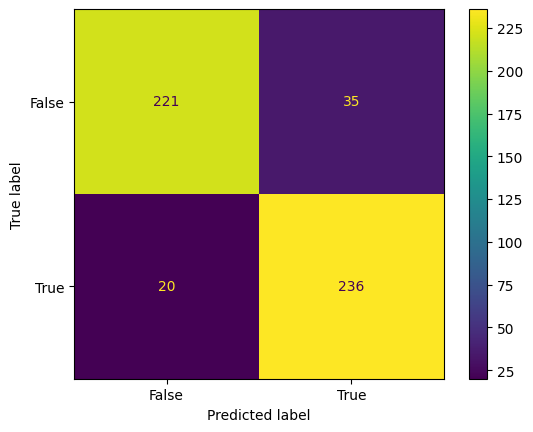

In [22]:
cm = confusion_matrix(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy().round())
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.show()

In [31]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(path):
    model = Model(hidden_channels=32, out_channels=32, metadata=train_data.metadata())
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model

In [ ]:
#save_model(model, "models/gnn_01.pth")

In [34]:
model = load_model("models/gnn_01.pth")

RuntimeError: Error(s) in loading state_dict for Model:
	Missing key(s) in state_dict: "app_lin.weight", "app_lin.bias". 
	size mismatch for gnn.conv2.user__recommends__app.lin_l.weight: copying a param with shape torch.Size([16, 32]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for gnn.conv2.user__recommends__app.lin_l.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for gnn.conv2.user__recommends__app.lin_r.weight: copying a param with shape torch.Size([16, 32]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for gnn.conv2.app__rev_recommends__user.lin_l.weight: copying a param with shape torch.Size([16, 32]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for gnn.conv2.app__rev_recommends__user.lin_l.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for gnn.conv2.app__rev_recommends__user.lin_r.weight: copying a param with shape torch.Size([16, 32]) from checkpoint, the shape in current model is torch.Size([32, 32]).

In [ ]:
model